#**<center> Classification of vegetal species given their leaves </center>**
    
&nbsp;       
    
#### <center> *Michele Filippini 275902* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *Pietro Recalcati 276963* </center>




## Contents



1.   [Introduction](#Introduction)
2.   [Features](#Features)
3.   [Dataset details and data exploration](#Dataset-details-and-data-exploration)
  - [Exploratory data analysis](#Exploratory-data-analysis)
  - [Outliers Removal](#outliers-removal)     
5.   [Splitting data in test and train set](#splitting-data-in-test-and-train-set)
  - [Balancing classes](#balancing-classes)
6.   [Decision Tree and Random Forest](#decision-tree-and-random-forest)
  - [Decision tree](#Decision-tree)
  - [Random forest](#Random-forest)
7.   [PCA](#PCA)
8.   [KNN Classifier](#KNN-classifier)
9.   [Logistic Regression](#Logistic-Regression)
10.  [SVM](#SVM)
  - [Linear SVM](#Linear-SVM)
  - [Non-Linear SVM](#Non-Linear-SVM)
11.  [Conclusions](#conclusions)



# Introduction

The goal of this work is to be able to discriminate plant species by their leaves. The source dataset (https://archive.ics.uci.edu/ml/datasets/Leaf) contains information about 443 different specimens belonging to 40 vegetal species.
For complex and/or composite leaf types the datasets includes an RGB picture only, while, for the remaining ones, measurements of shape and colour are made available as well, together with a BW image. 
Our analysis focuses on numerical measurements, therefore ignores the pictures and considers a subset of 30 categories among the original 40. The plant recognition task can be formalized as a classification problem, where the information about colour and shape of the leaf constitute the input features and the plant species are the output labels.
The following sections describe the procedure that was applied and the machine learning models that were chosen to address this problem.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import sys
import graphviz
import math

from math import ceil
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import f1_score, recall_score, precision_score
from statistics import mean
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [4]:
RANDOM_STATE = 1234
AVERAGE = 'macro'

# Features

1.   **Class (Species)**: species the plant belongs to (classification target)
2.   **Specimen number**: unique number of the plant among the given class
3.   **Eccentricity**: ratio between the semidistance between foci and the longest semi axe
4.   **Aspect Ratio**: ratio between the horizontal and vertical "diameters"
5.   **Elongation**: defined as 1 minus the ratio between the diameters of the largest inscribed circle and the smallest circumscribed one
6.   **Solidity**: ratio between the area of the leaf and the one of its convex hull
7.   **Stochastic Convexity**: estimated probability of a random segment to be fully contained inside the leaf
8.   **Isoperimetric Factor**: proportional to the ratio between the area and the square of the perimeter of the leaf
9.   **Maximal Indentation Depth**: considering the distance $d_1$, between the hull centroid and a point of the hull, and the distance $d_2$, between the centroid and the point on the leaf border at the same angle, the max indentation depth is the maximum of the difference between $d_1$ and $d_2$, divided by the hull perimeter
10.  **Lobedness**: characterizes how lobed a leaf is
11.  **Average Intensity**: mean of the image intensity calculated on all pixels
12.  **Average Contrast**: standard deviation of the intensity
13.  **Smoothness**: measures the relative smoothness of the image intensity
14.  **Third Moment**: third moment of the image intensity
15.  **Uniformity**: sum of the squared probabilities of different intensity levels
16.  **Entropy**: entropy of the random variable modelling pixel intensity

The figure below provides an overview of the general aspect of the
leaves of each plant.   
   
   
![leaves](images/leaves.jpg)


# Dataset details and data exploration

## Exploratory data analysis

In this section we want to report some general observations regarding the nature of the data contained within our dataset. 
Observing the data we realized that the "Specimen number" column, which consists of an enumerator for the leaves belonging to the same class,
it is not significant for the analysis and therefore we have decided to remove it. 

In [5]:
# Read dataset
df = pd.read_csv('leaf.csv')

# Remove identifiers (useless for data analysis)
df = df.drop(columns='Specimen Number')

# Show information related only to the columns of interest for the analysis (no classes)
df.iloc[:, 1:].describe()

,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
count,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,0.719854,2.440210,0.513760,0.904158,0.943793,0.531234,0.037345,0.523845,0.051346,0.124535,0.017670,0.005928,0.000387,1.162630
std,0.208311,2.599043,0.195583,0.114639,0.115047,0.217532,0.038575,1.039639,0.035965,0.051860,0.013755,0.005294,0.000431,0.584854
min,0.117080,1.006600,0.107610,0.485490,0.396490,0.078376,0.002837,0.001464,0.005022,0.033415,0.001115,0.000229,0.000007,0.169400
25%,0.550622,1.211300,0.349623,0.890667,0.966230,0.346818,0.009521,0.016500,0.022843,0.083362,0.006901,0.002080,0.000102,0.718900
50%,0.763450,1.570750,0.501855,0.948130,0.992980,0.579160,0.023860,0.103615,0.042087,0.119375,0.014050,0.004447,0.000239,1.077450
75%,0.895097,2.343100,0.633373,0.976897,1.000000,0.700712,0.047834,0.416433,0.073046,0.163795,0.026127,0.008307,0.000516,1.554575
max,0.998710,19.038000,0.948340,0.993880,1.000000,0.858160,0.198980,7.206200,0.190670,0.280810,0.073089,0.029786,0.002936,2.708500


As you can see within the dataset there are no *null* values ​​and there are no categorical values ​​so it is not necessary to operate any encoding technique.
The dataset as a whole consists of 340 data points described by 14 features (15 before removal). 

In [6]:
print(f'The column with at least one null element are {sum(df.isnull().sum())}')
print((f'The shape of our data is {df.shape}'))

The column with at least one null element are 0
The shape of our data is (340, 15)


In [7]:
# code to verify that all features are numerical
print(df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all()))

Class (Species)              True
Eccentricity                 True
Aspect Ratio                 True
Elongation                   True
Solidity                     True
Stochastic Convexity         True
Isoperimetric Factor         True
Maximal Indentation Depth    True
Lobedness                    True
Average Intensity            True
Average Contrast             True
Smoothness                   True
Third moment                 True
Uniformity                   True
Entropy                      True
dtype: bool


We have also reported the graph corresponding to the number of records per class from which it can be observed that the classes are not equally distributed even if there are no too significant differences.

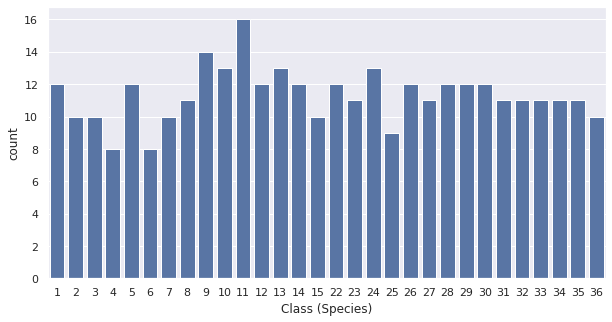

In [8]:
fig = plt.figure(figsize=(10,5))

sns.set(style="darkgrid")
sns.countplot(x="Class (Species)", data=df, color='b')

plt.show()

Given the large number of classes, it is not possible to show through the violin plots for each feature what its distribution is in correspondence with the various classes as the graph would be difficult to interpret.
Nevertheless, we have decided to report the plots related to each feature to be able to observe its distribution.

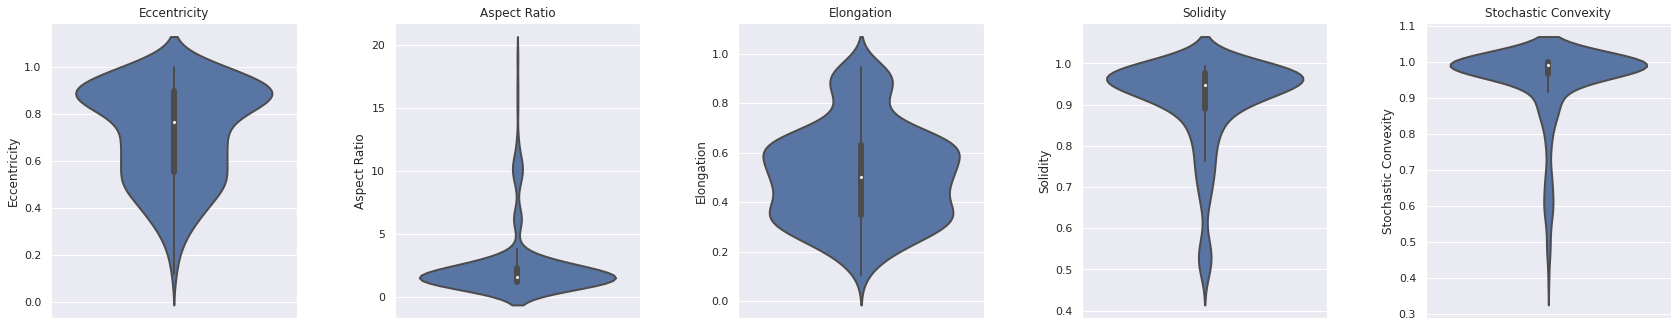

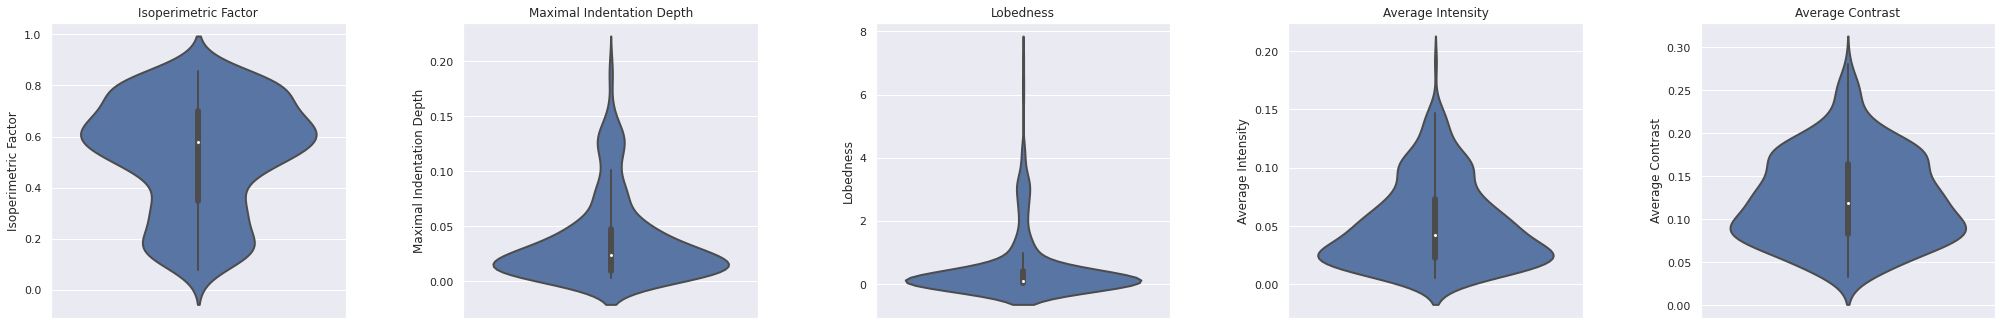

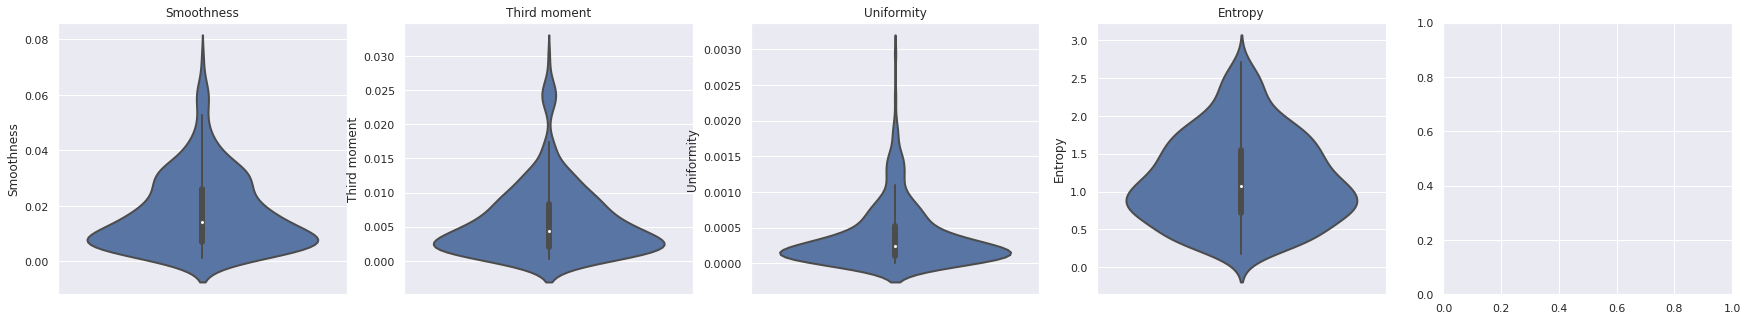

In [9]:
def print_violin_plots(df, n_rows=3):

  n_cols = ceil((len(df.columns) - 1) / n_rows)

  row = 0
  col = 0
  
  fig, axes = plt.subplots(1, n_cols, figsize=(25,5))
  
  for feature in df.columns[1:]:
    if col == n_cols:
      row = row + 1
      col = 0
      plt.subplots_adjust(top=0.90, bottom=0.08, left=0.05, right=0.95, hspace=0.25, wspace=0.4)
      fig, axes = plt.subplots(1, n_cols, figsize=(30,5))
    
    sns.violinplot(y=feature, data=df, ax=axes[col],orient='v',linewidth=2)
    axes[col].set_title(feature)
    col = col + 1

print_violin_plots(df)

 It is possible to observe how the various features assume very different values ​​from each other. For example *Aspect Ratio* assumes values ​​much greater than zero when arriving
to a maximum value greater than 17.5, while features such as *Third Moment* assume values 3 orders of magnitude smaller. In order for all the features to have the same range of values ​​it is necessary to operate some operations such as *normalization*, carried out by us through the *MinMaxScaler* method of scikit-learn.
This operation is fundamental for all those algorithms that base their operation on the calculation of distances, which we will also face in the course of the analysis, such as: KNN and SVM. This operation is also very important for the next step that we are going to take regarding the removal of the outliers.
The normalization applied to the dataframe consists in associating to each feature values ​​between 0 and 1. 

$$MinMax(x_i) = \frac{x_i - min(x)}{max(x) - min(x)}$$

In [10]:
def min_max_scaled(df):
  
  cols = df.columns.tolist()
  cols = cols[1:]

  min_max_scaler = MinMaxScaler()

  df[cols] = min_max_scaler.fit_transform(df[cols])

  return df

df = min_max_scaled(df)

 The effect of normalization is easily visible through the boxplots.
 

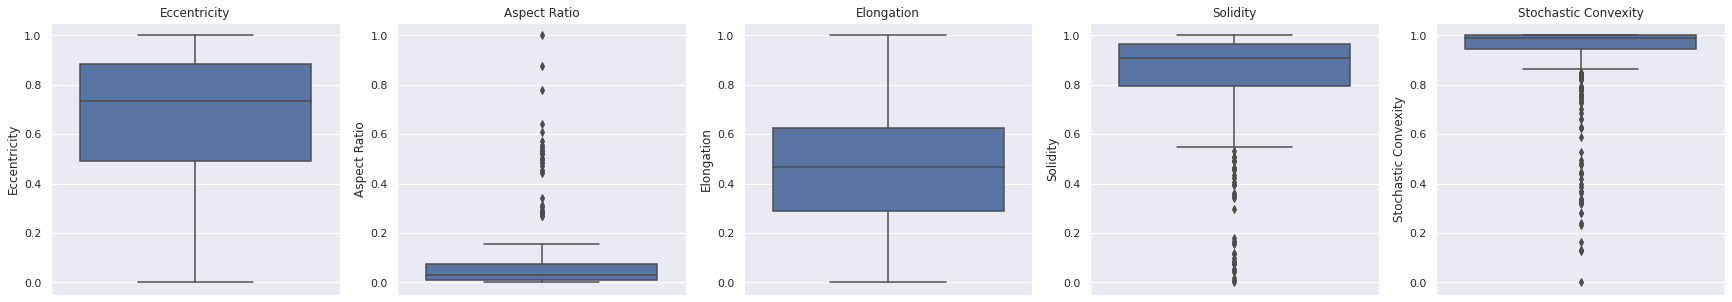

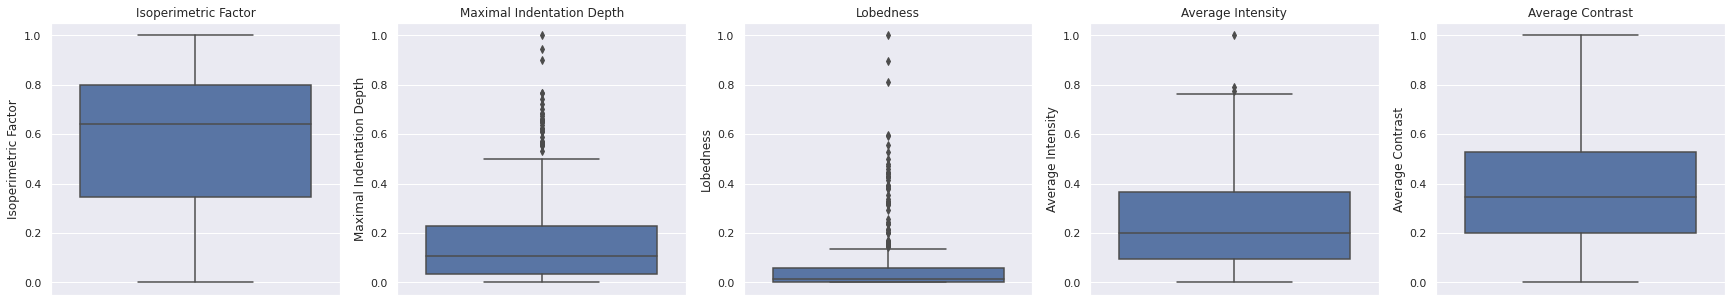

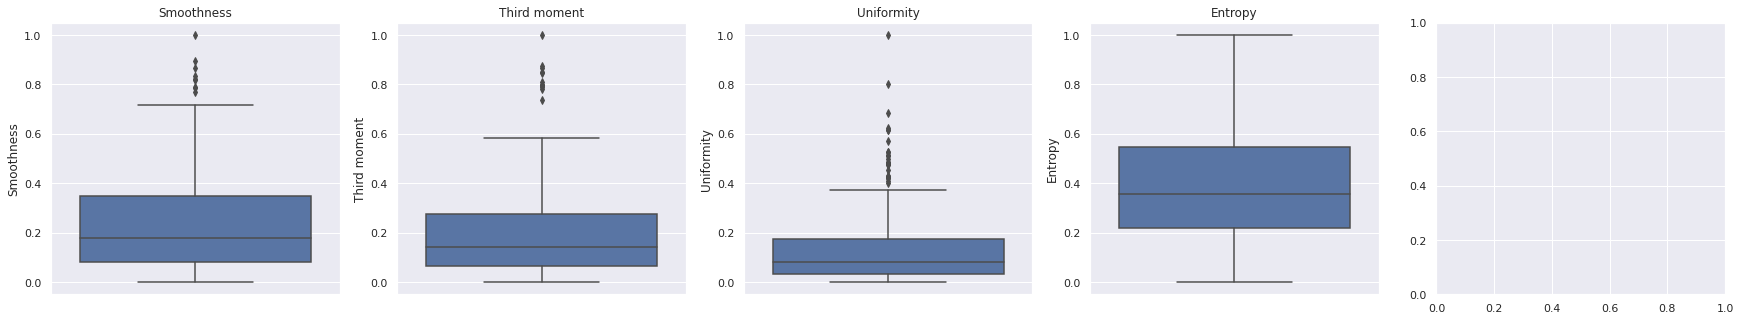

In [11]:
def print_boxplots(df, n_rows=3):

  n_cols = ceil((len(df.columns) - 1) / n_rows)

  row = 0
  col = 0
  
  fig, axes = plt.subplots(1, n_cols, figsize=(30,5))
  
  for feature in df.columns[1:]:
    if col == n_cols:
      row = row + 1
      col = 0
      fig, axes = plt.subplots(1, n_cols, figsize=(30,5))
    
    sns.boxplot(y=feature, data=df, ax=axes[col])
    axes[col].set_title(feature)
    col = col + 1

print_boxplots(df)

From the correlation matrix we can see how much each couple of features is correlated. The matrix is symmetric since the order of the two features is not relevant. Values close to 1 indicate strong positive correlation, while values close to -1 indicate strong negative correlation. In both cases this is a symptom of some kind of redundancy in the data, since by observing one of the features it is possible to make inferences on the other. This redundancy can be removed without losing too much information by applying a dimensionality reduction technique such as Principal Components Analysis. Entries in the matrix obtained from the Leaf dataset show a wide range of values, going from -0.82 to 0.98, with some cells very close to zero. The most correlated pair is Smoothness-Average Contrast (0.98), while the most uncorrelated is Aspect Ratio-Solidity. Since many pairs of predictors show high correlation values, it is very likely that a few principal components could explain a large portion of the total dataset variance.

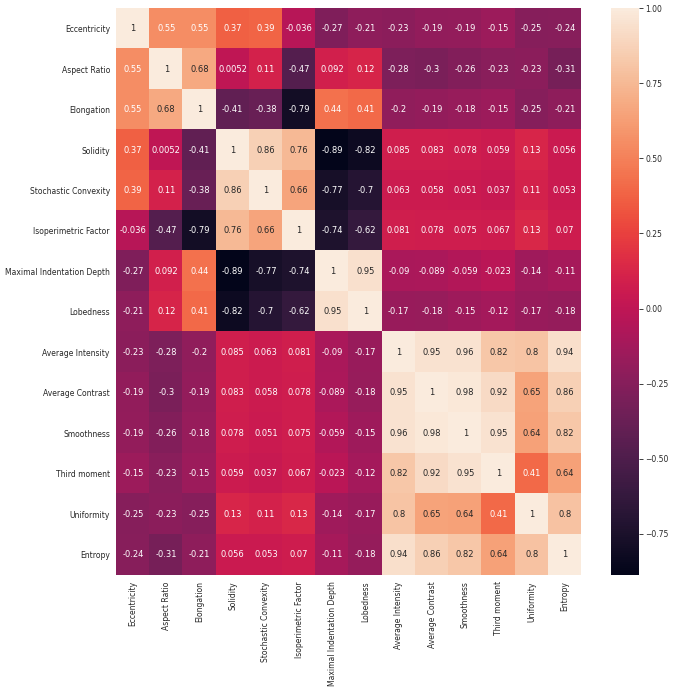

In [12]:
def print_correlation_matrix(df):
  
  corrmat = df.corr()
  plt.figure(figsize=(15,15),dpi=50)
  sns.heatmap(corrmat, annot=True)

print_correlation_matrix(df[df.columns[1:]])

## Outliers Removal
Detecting outliers in a multivariate dataset can be considered as one of the challenges of the data preprocessing phase. There are various distance metrics, scores and techniques to detect outliers.
Euclidean distance is one of the most known distance metrics to identifiy outliers based on their distance to the center point. Different methods consider outliers from different perspectives. It is important to 
understand that outliers found based on one method may not be discovered by others. In our analysis we decided to try three different techniques.    
   
The first is based on the information that is provided to us by the boxplots of each predictor. Through values of the 25th percentile, 75th percentile and of Inter quartile range obtained from the previous two with some operations it is possibile to define thresholds of values that allow you to define when the value of a given feature can be considered an outlier or not. By applying this technique, the data points, originally 340, are reduced to 211. However, this technique does not seem to us the most appropriate because it considers only the single features separately without taking into account the distribution of the whole data. Furthermore, the data considered as outliers and consequently discarded are too many considering that the originally available dataset is quite small.   


In [13]:
def inter_quartile_range(arr):
  arr = np.array(sorted(arr))
  Q1=np.quantile(arr, 0.25)
  Q3=np.quantile(arr, 0.75)
  IQR=Q3-Q1
  return IQR, Q1, Q3

In [14]:
# Unidimensional oultiers removal

def without_outliers(df):

  filter = [ True for _ in range(df.shape[0]) ]

  for feature in df.columns[1:]:
    
    values = df[feature].values
    iqr, q1, q3 = inter_quartile_range(values)

    for i, val in enumerate(values):
      if val < (q1 - 1.5 * iqr) or val > (q3 + 1.5 * iqr):
        # Element is an outlier
        filter[i] = False

  return df[filter]

print(df.shape, without_outliers(df).shape)

(340, 15) (211, 15)


We then explored a second and third techniques, based on Mahalanobis and Euclidean distances. Mahalanobis Distance ($
\sqrt{ (\vec{x} - \vec{y})^T {\rm \bf C}^{-1} (\vec{x} - \vec{y}) }
$) is an effective distance metric that finds the distance between the point and distribution. It works quite effectively on multivariate data because it uses a covariance matrix of variables to find the distance between the data points and the center.
This metric detects outliers based on the distribution pattern of data points, unlike the Euclidean distance ($\sqrt {\sum_{i=1}^{n}  \left( x_{i}-y_{i}\right)^2 } $). Even in these distance-based techniques, outliers detection was achieved through the use of boxplots. For each of them we built a boxplot on the basis of the distances and used the procedure described above to identify the outliers. Below we reported an image as example of the difference between using the two distances.

![mahalanobis-vs-euclidean](images/Euclidean_vs_Mahalanobis.jpeg)

The main reason for this difference is the covariance matrix because covariance indicates how variables variate together. The use of the covariance in the computation of the distance between the central point and the rest also in an *n*-dimensional space allows obtaining the real threshold based on the variation. In our analysis we noticed how the Euclidean distance-based technique results in a small decrease in data (only 6 outliers are detected). However, given the explanation before we decided to adopt the Mahalanobis method thus reducing the size of the dataset to 328. Since there is no information about a previous removal of the outliers relating to the our dataset, we decided to carry out this cleaning.

In [ ]:
# Multidimensional outliers detection (using euclidean distance)

def without_multidimensional_outliers_euclidean(df):

  mean_point = df[df.columns[1:]].mean()

  distances_from_mean_point = (df[df.columns[1:]] - mean_point).pow(2).sum(1).pow(0.5)

  iqr, q1, q3 = inter_quartile_range(distances_from_mean_point)

  filter = [ True for _ in range(df.shape[0]) ]

  for i, val in enumerate(distances_from_mean_point):
    if val > (q3 + 1.5 * iqr):
      # Element is an outlier
      filter[i] = False
  
  return df[filter]


print(df.shape, without_multidimensional_outliers_euclidean(df).shape)

(340, 15) (334, 15)


In [ ]:
# Multidimensional outliers detection (using Mahalanobis distance)

def without_multidimensional_outliers_mahalanobis(df):

  df_o = df.copy()
  df_o = df_o.drop(columns= 'Class (Species)')
  df_o = df_o.to_numpy()

  covariance  = np.cov(df_o , rowvar=False)

  # Covariance matrix power of -1
  covariance_pm1 = np.linalg.matrix_power(covariance, -1)

  # Center point
  center_point = np.mean(df_o , axis=0)

  distances = []
  distances_without_outliers = []
  for i, val in enumerate(df_o):
        distance = math.sqrt((val - center_point).T.dot(covariance_pm1).dot(val - center_point))
        distances.append(distance)

  iqr, q1, q3 = inter_quartile_range(distances)

  filter = [ True for _ in range(len(distances)) ]

  for i, val in enumerate(distances):
    if val > (q3 + 1.5 * iqr):
      # Element is an outlier
      filter[i] = False

  return df[filter]

print(df.shape, without_multidimensional_outliers_mahalanobis(df).shape)

(340, 15) (328, 15)


In [ ]:
df = without_multidimensional_outliers_mahalanobis(df)

# Splitting data in test and train set

Classifiers applied in real-world scenarios are typically working on “unseen” data, therefore, in order to fairly assess the quality of a model, the labeled samples used to evaluate its accuracy must not be exploited at training time. To do so, the dataset was split in two subsets by sampling 20% of the original records to be later used for testing purposes. The chosen ratio between test and train instances takes into account the low cardinality of the Leaf dataset with respect to the number of classes.     
Since most datasets are unbalanced in terms of classes, it is usually required to apply a so-called *stratified sampling* technique to preserve proportions when selecting test records. Failing to do this can lead to some categories being misrepresented (or even missing) in the test set, negatively affecting quality estimates.

## Balancing classes

A large difference in the number of training samples between different categories can cause a classifier to be biased towards the most common ones, up to the extreme case in which it always labels data with the majority class. Given that every category is equally important, a balancing strategy should be implemented before using the data to train a model. The following four solutions are proposed:    
* **Undersampling**: from each class a number of records equal to the frequency of the rarest one is sampled without replacement. The lack of duplicated data reduces risks of overfitting.

* **Oversampling**: from each class a number of records equal to the frequency of the most common one is sampled with replacement. Does not discard any sample from the original dataset.
* **Trade-off**: undersampling has a negative impact on already small datasets (such as Leaf) because it would shrink them even more. On the other hand, the large relative difference in frequency between classes would cause an oversampled set to contain a large percentage of duplicated records. For these reasons, the third strategy tries to reach a trade-off between the previous ones with the goal of mitigating their respective drawbacks. Initially the average class frequency $f_c$ is computed on the unbalanced training set, then each class which is more frequent than $f_c$ is under sampled, while rarer classes are oversampled to the average frequency.
* **No balancing**: the training set does not undergo any sampling process.

In [ ]:
def split_train_test(df):

  X = df.iloc[:, 1:15]
  y = df.iloc[:, 0]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

  df_train = X_train.copy()
  df_train.insert(0, 'Class (Species)', y_train)

  return df_train, X_test, y_test

def do_random_over_under_sampling(df_input):

  df = df_input.copy()

  df_result = None
  counts = df['Class (Species)'].value_counts()
  average = int(counts.mean())

  for c, count in counts.items():

    df_class = df.loc[df['Class (Species)'] == c]

    if count > average:

      df_class = df_class.sample(n=average, replace=False, random_state=RANDOM_STATE)

    elif count < average:

      df_class = df_class.sample(n=average, replace=True, random_state=RANDOM_STATE)

    if df_result is None:
      df_result = df_class
    else:
      df_result = pd.concat([df_result, df_class])

  return df_result

In [ ]:
def do_random_oversampling(df_input):

  df = df_input.copy()

  df_result = None
  counts = df['Class (Species)'].value_counts()
  max_value = counts.max()

  for c, count in counts.items():

    df_class = df.loc[df['Class (Species)'] == c]

    if count < max_value:

      df_class = df_class.sample(n=max_value, replace=True, random_state=RANDOM_STATE)

    if df_result is None:
      df_result = df_class
    else:
      df_result = pd.concat([df_result, df_class])

  return df_result

In [ ]:
def do_random_undersampling(df_input):

  df = df_input.copy()

  df_result = None
  counts = df['Class (Species)'].value_counts()
  min_value = counts.min()

  for c, count in counts.items():

    df_class = df.loc[df['Class (Species)'] == c]

    if count > min_value:

      df_class = df_class.sample(n=min_value, replace=False, random_state=RANDOM_STATE)

    if df_result is None:
      df_result = df_class
    else:
      df_result = pd.concat([df_result, df_class])

  return df_result

In [ ]:
df_train_original, X_test, y_test = split_train_test(df)

df_train_undersampling = do_random_undersampling(df_train_original)
df_train_oversampling = do_random_oversampling(df_train_original)
df_train = do_random_over_under_sampling(df_train_original)

The following graphs show the comparison of the results obtained through different sampling techniques

Text(0.5, 1.0, 'Original train')

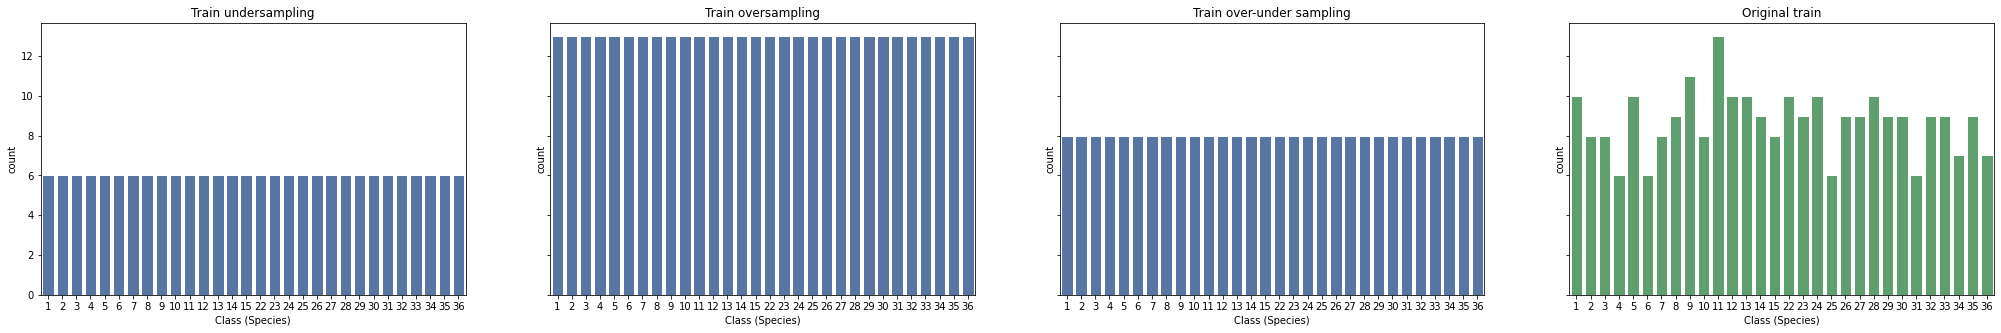

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(35,5), sharey=True)
sns.set(style="darkgrid")
sns.countplot(x="Class (Species)", data=df_train_undersampling, color='b', ax=axes[0])
axes[0].set_title('Train undersampling')
sns.countplot(x="Class (Species)", data=df_train_oversampling, color='b', ax=axes[1])
axes[1].set_title('Train oversampling')
sns.countplot(x="Class (Species)", data=df_train, color='b', ax=axes[2])
axes[2].set_title('Train over-under sampling')
sns.countplot(x="Class (Species)", data=df_train_original, color='g', ax=axes[3])
axes[3].set_title('Original train')

Having applied the *min_max_scaler* before removing the outliers, a further operation is required before feeding data to the learning algorithms. Since PCA requires data to be zero-centered and have the same standard deviation for each feature the *StandardScaler* method of scikit-learn was chosen. 


$$StandardScaled(x_i) = \frac{x_i - \mu(x)}{\sigma(x)}$$

In [ ]:
def StandardScaler_df_columns(df, X_test):

  X_t = X_test.copy()

  X_train = df.iloc[:, 1:]
  y_train = df.iloc[:, 0]

  cols = df.columns.tolist()
  cols = cols[1:]

  stand_scaler = StandardScaler()

  X_train[cols] = stand_scaler.fit_transform(X_train[cols])
  X_t[cols] = stand_scaler.transform(X_t[cols])

  return X_train, y_train, X_t

In [ ]:
X_test_original = X_test.copy()

X_train, y_train, X_test = StandardScaler_df_columns(df_train, X_test)
X_train_under, y_train_under, X_test_under = StandardScaler_df_columns(df_train_undersampling, X_test_original)
X_train_over, y_train_over, X_test_over = StandardScaler_df_columns(df_train_oversampling, X_test_original)
X_train_original, y_train_original, X_test_original = StandardScaler_df_columns(df_train_original, X_test_original)

data_dict = {
    "OriginalData" : [X_train_original, y_train_original, X_test_original, y_test],
    "OverSamplingData" : [X_train_over, y_train_over, X_test_over, y_test],
    "UnderSamplingData" : [X_train_under, y_train_under, X_test_under, y_test],
    "OverUnderSamplingData" : [X_train, y_train, X_test, y_test]
}

In [ ]:
list_f1_scores_classifier = [[] for i in range(6)]

# Decision Tree and Random Forest
Decision tree is a very powerful machine learning alogorithm that can be used both for classification and regression. In our analysis we focus only on classification since data are labeled in classes.   
In the learning phase, the operations carried out by the algorithm can be summarized in the following way: the predictor space is divided into $J$ distinct and non-overlapping regions $R_1,R_2,... , R_j$. For every observation
that falls into the region $R_j$ the tree makes the same prediction which corresponds, in classification, to the most commonly occurring class of training observation in the region to which it belongs. In theory, the regions could have any shape but for sake of simplicity we can imagine that the algorithm divides the predictor space into high-dimensional rectangles, also called boxes. The final goal is to find boxes $R_1, ... , R_j$ which are able to minimize the *classification error rate* defined as $1 - \max_{k}(\widehat{p}_{mk})$, a natural alternative to *Residual Sum of Squares* (RSS) for classification. This value is simply the fraction of training observations in that region that do not belong to the most common class. The formula reported above is about a single region $m$ and $p_{mk}$ corresponds to the probability of $k$-th class in $m$.   
However, this procedure
is computationally infeasible because it should consider together all possible partitions that, even in a finite set, turn out to be an indefinite number. For this reason is introduced a top-down greedy approach known as recursive binary splitting.    
It begins at the root of the tree and successively splits the predictor space. It is called greedy because at each step of the tree building process the best split is made at each particular step so it is only locally optimum and not globally. Since the classification error rate metric is not sufficiently sensitive for tree-growing, two other measures are preferable: 
- **Gini index** , which measures the total variance across different $K$ classes. It takes on a small value if the $p_{mk}$ are unbalanced: for this reason Gini is referred to as a measure of node purity. A small value indicates that the node contains predominantly observations from a single class. 
$$\sum_{k=1}^{K}\widehat{p}_{mk}(1-\widehat{p}_{mk})$$

- **Cross-entropy** which is numerically very similar to the first one.    
$$ -\sum_{k=1}^{K}\widehat{p}_{mk}\log{(\widehat{p}_{mk})}$$

Decision trees show many advantages: are very easy to explain to people, mainly when the number of classes and the depth are not too high, can be displayed graphically and are easily interpreted even by a non-expert and they can also easily handle qualitative predictors.     
However this method suffers from high variance. This means that small changes in the trainig set correspond to very different result in prediction.    

*Bootstrap aggregation*, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method. The main idea behind this concept is to aggregate different models built on a weak learner to make something stronger with respect to the single result. The proof of this idea is a standard result in probability according to which given a set of obseravation each of them with variance $\sigma^2$, the variance of the mean of those observation is lower with respect the single one of each variable. In other words, averaging a set of observation reduces variance. 
This idea is not practical because generally speaking the training set is only one and not many. For this reason the concept of Bootstrap is introduced. Bootstrapping a dataset consists in taking repeated samples from a single training set. We can generate different bootstrapped training sets in order to get multiple predictions at a given point. The final result consists in averaging over all predictions, or, in case of classification, taking the majority vote.   

Random forest provides an improvement over bagged trees via a small tweak that decorrelates the trees. As described in bagging through this model we build a number of decision trees on bootstrapped training samples but at each split for each tree only a random selection of $m$ predictors is chosen as split candidates from the full set of $p$ 
predictors. The reason behind this choice is due to the presence of very strong predictors that tend to be always the same in each tree, we want to avoid this phenomenon due to a high correlation. 

## Decision Tree

In [ ]:
parameters = {'criterion':('gini','entropy'),
'min_samples_split':[2,3,5,7,10],
'max_depth':[4,5,6,7,8,9,10,15,20,30],
'min_samples_leaf':[1,2,4],
'random_state': [RANDOM_STATE]
}

def decision_tree_classifier(parameters, cvfolds_number, X_train, y_train, output_filename):

  tree_cf = DecisionTreeClassifier()
  tree_model = GridSearchCV(tree_cf, parameters, cv=KFold(cvfolds_number, shuffle=True, random_state=RANDOM_STATE))
  tree_model.fit(X_train, y_train)

  tree_model = tree_model.best_estimator_
  
  dot_data= export_graphviz(tree_model, out_file=None, feature_names=X_train.columns,
                           filled=True, rounded=True, special_characters=True)

  graph = graphviz.Source(dot_data,format='png')
  out = graph.render(filename=output_filename)

  return tree_model

In [ ]:
def tree_computations(parameters, data_dict):

  tree_matrix = []

  for samplingType in data_dict.keys():
    
    tree_model = decision_tree_classifier(parameters, 5, data_dict[samplingType][0], data_dict[samplingType][1], f'tree/{samplingType}')
    Y_pred = tree_model.predict(data_dict[samplingType][2])
  
    list_result = []
    list_result.append(round(tree_model.score(data_dict[samplingType][2], data_dict[samplingType][3]), 2))
    list_result.append(round(precision_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))
    list_result.append(round(recall_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0),2))
    list_result.append(round(f1_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))

    tree_matrix.append(list_result)

  return tree_matrix

In [ ]:
tree_matrix = tree_computations(parameters, data_dict)
list_f1_scores_classifier[0] = np.array(tree_matrix)[:,3]

In [ ]:
def print_results(scoring_matrix, data_dict, classifier_name):

  score_methods = ['accuracy', 'precision', 'recall', 'f1']
  sampling_types = data_dict.keys()

  for row, samplingType in enumerate(sampling_types):

    for col, scoreMethod in enumerate(score_methods):

      print(f'{scoreMethod} {classifier_name} classifier - {samplingType} : {scoring_matrix[row][col]}')

    print('\n')

In [ ]:
print_results(tree_matrix, data_dict, 'tree')

accuracy tree classifier - OriginalData : 0.65
precision tree classifier - OriginalData : 0.64
recall tree classifier - OriginalData : 0.63
f1 tree classifier - OriginalData : 0.61


accuracy tree classifier - OverSamplingData : 0.67
precision tree classifier - OverSamplingData : 0.67
recall tree classifier - OverSamplingData : 0.65
f1 tree classifier - OverSamplingData : 0.62


accuracy tree classifier - UnderSamplingData : 0.65
precision tree classifier - UnderSamplingData : 0.62
recall tree classifier - UnderSamplingData : 0.64
f1 tree classifier - UnderSamplingData : 0.61


accuracy tree classifier - OverUnderSamplingData : 0.58
precision tree classifier - OverUnderSamplingData : 0.57
recall tree classifier - OverUnderSamplingData : 0.57
f1 tree classifier - OverUnderSamplingData : 0.53




In [ ]:
def plot_scores_of_given_model(scoring_matrix, classifier_name):

  score_methods = ['accuracy', 'precision', 'recall', 'f1']
  sampling_methods = ['OriginalData', 'OverSamplingData', 'UnderSamplingData', 'OverUnderSamplingData']

  x_groups = len(score_methods)
  element_per_group = len(sampling_methods)
  index = np.arange(x_groups)
  width = 0.15

  fig, ax = plt.subplots(1,1, figsize=(15,8))
  plots = [None] * element_per_group
  elements = np.array(scoring_matrix)

  for i in range(element_per_group):
    plots[i] = ax.bar(index + i*width, elements[i, :], width=width, label=sampling_methods[i])

  ax.set_title(f'Comparison of different scoring measures for {classifier_name} classifier', fontsize = 15)
  ax.set_xticklabels(score_methods, fontsize=12)
  ax.set_xticks(index + width * element_per_group / 2)
  ax.legend(plots, sampling_methods, loc='upper center', bbox_to_anchor=(1, 1.15),
            ncol=1, fancybox=True, shadow=True)

plt.show()

In our analysis we decided to use *Accuracy*, *Precision*, *Recall* (*Sensitivity* in binary classification) and *f1-score* to compare algorithms and sampling techniques (formulas reported below refer to the binary case):


![Confusion Matrix](images/confusionMatrix.png)


**f1-score**: $$\frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2TP+FP+FN}$$

All the results that we will compare, in this and in all subsequent algorithms, are obtained from optimal models whose hyperparameters have been obtained through the *k-fold cross-validation* technique. In our analysis we kept the fold number fixed at 5 for all models. 

For the decision tree, the comparison between different techniques shows that oversampling gives the best results for all the metrics, slightly better than the original data.

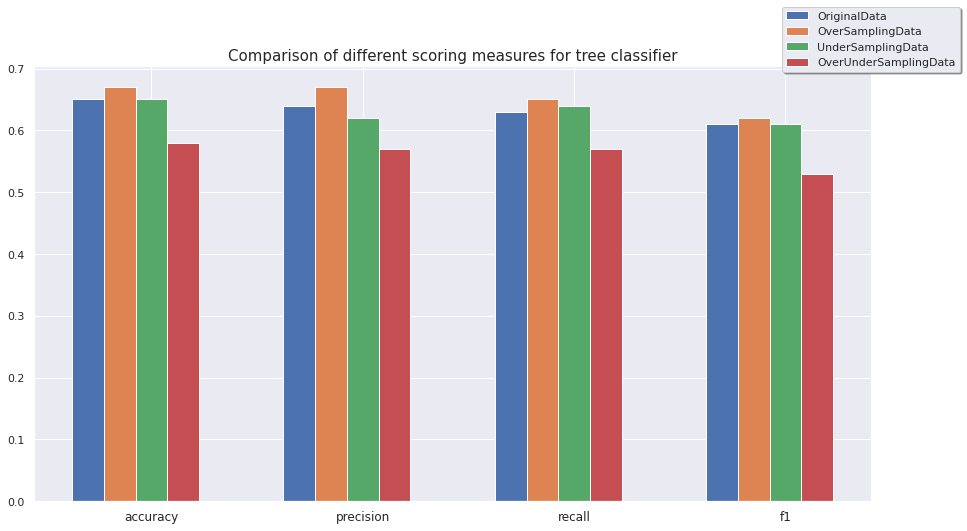

In [ ]:
plot_scores_of_given_model(tree_matrix, 'tree')

## Random Forest

In [ ]:
rf_hyperparameters = {
'criterion':('gini','entropy'),
"max_depth" : [5,6,7,8,9],
"n_estimators": [10, 20, 30, 50, 100],
"max_features": ["sqrt", 0.10, 0.20, 0.25, 0.30, 1]
}

In [ ]:
def random_forest_classifier(rf_hyperparameters, cvfolds_number, X_train, y_train):

  rf_cf = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=8, min_samples_leaf=1, min_samples_split=3, criterion='entropy')
  grid_search = GridSearchCV(rf_cf, rf_hyperparameters, cv=KFold(cvfolds_number, shuffle=True, random_state=RANDOM_STATE), n_jobs= -1)

  grid_search.fit(X_train, y_train)
  rf_model = grid_search.best_estimator_

  return rf_model

In [ ]:
def features_importance(model, X_train, data_dict, index):

  x_val = [x+1 for x in range(model.feature_importances_.__len__())]

  pair_val = []
  cols_name = []

  for key,val in zip(x_val,model.feature_importances_):
    pair_val.append([key,val])

  pair_val = sorted(pair_val, key=functools.cmp_to_key(lambda x,y: y[1]-x[1]))

  y_val = [x[1] for x in pair_val]
  x_val = [x[0] for x in pair_val]

  plt.figure(figsize=(10,5))
  ax = sns.barplot(y=y_val,x=x_val,order=x_val)

  for val in x_val:
    cols_name.append(X_train.columns[val-1])

  ax.set_title(f'Importance of each feature random-forest classifier - {list(data_dict.keys())[index]}')
  ax.set_xticklabels(cols_name, rotation='vertical', fontsize=10)
  plt.show()

In [ ]:
def random_forest_computations(parameters, data_dict):

  rf_matrix = []
  models_list = []

  for samplingType in data_dict.keys():

    rf_model = random_forest_classifier(parameters, 5, data_dict[samplingType][0], data_dict[samplingType][1])
    Y_pred = rf_model.predict(data_dict[samplingType][2])

    models_list.append(rf_model)
  
    list_result = []
    list_result.append(round(rf_model.score(data_dict[samplingType][2], data_dict[samplingType][3]), 2))
    list_result.append(round(precision_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))
    list_result.append(round(recall_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0),2))
    list_result.append(round(f1_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))

    rf_matrix.append(list_result)

  return rf_matrix, models_list

In [ ]:
rf_matrix, rf_models_list = random_forest_computations(rf_hyperparameters, data_dict)
list_f1_scores_classifier[1] = np.array(rf_matrix)[:,3]

In [ ]:
print_results(rf_matrix, data_dict, 'random_forest')

accuracy random_forest classifier - OriginalData : 0.79
precision random_forest classifier - OriginalData : 0.75
recall random_forest classifier - OriginalData : 0.77
f1 random_forest classifier - OriginalData : 0.74


accuracy random_forest classifier - OverSamplingData : 0.76
precision random_forest classifier - OverSamplingData : 0.72
recall random_forest classifier - OverSamplingData : 0.74
f1 random_forest classifier - OverSamplingData : 0.71


accuracy random_forest classifier - UnderSamplingData : 0.7
precision random_forest classifier - UnderSamplingData : 0.7
recall random_forest classifier - UnderSamplingData : 0.69
f1 random_forest classifier - UnderSamplingData : 0.65


accuracy random_forest classifier - OverUnderSamplingData : 0.71
precision random_forest classifier - OverUnderSamplingData : 0.67
recall random_forest classifier - OverUnderSamplingData : 0.71
f1 random_forest classifier - OverUnderSamplingData : 0.67




In this case as well the oversampled data perform better than the undersampled ones, while the original data are better than all of the others.
As expected, the random forest classifier is able to improve over the decision tree by almost 10%.

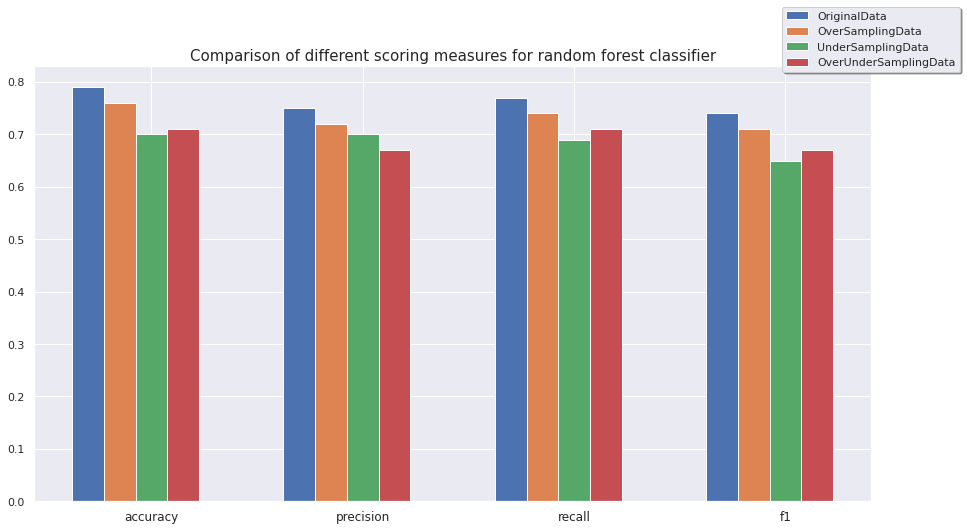

In [ ]:
plot_scores_of_given_model(rf_matrix, 'random forest')

Using the two best models, we extract the most important features used by the trees for classification. The top 5 features are similar between the two considered models, given in a different order.

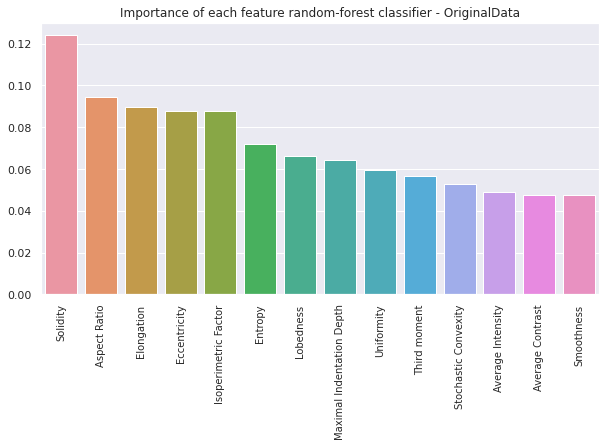

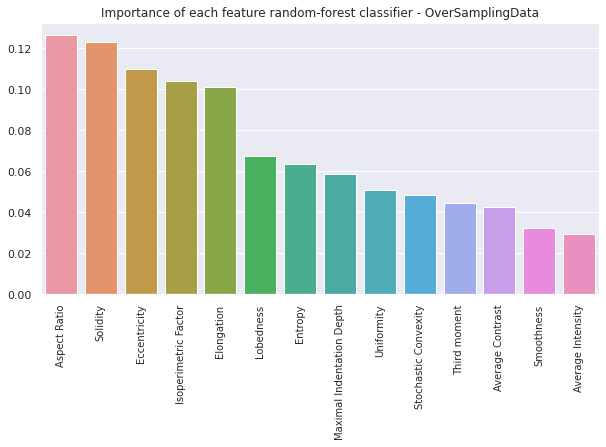

In [ ]:
features_importance(rf_models_list[0], X_train_under, data_dict, 0)
features_importance(rf_models_list[1], X_train, data_dict, 1)

# PCA

Working with high dimensional data can negatively affect some learning algorithms, leading to more complex models, longer processing delays and sometimes worse performances. Furthermore, some features may be highly correlated with the previous ones, thus not very useful for the learning procedure. However, dropping features usually causes a loss of information, even when correlation is high.
*Principal components analysis* (PCA) is an unsupervised machine learning technique for dimensionality reduction that can be applied to solve this issue. Indeed, PCA is an optimization problem that aims at finding a lower dimensional space on which data can be projected while minimizing the information loss.   
We can think of two different ways of reducing information loss, the first one being more "statistical" and the second one more "geometrical".   
According to the statistical approach, the goal is to compute the vector (called *First Principal Component*, or *PC1*) that identifies the direction of maximal variance in the dataset, expressed as a linear combination of the features. This is achieved by maximizing the variance of the data points projected on the direction of candidate vectors, whose length should be normalized since failing to do so could lead to arbitrarily large variances.    
Given $d$ predictors $z_i$ find $\alpha_i$ such that:
$$max(Var(\sum_{i=1}^d{\alpha_i \cdot z_i}))$$
$$\sum_i{\alpha_{i}^2} = 1$$
Further principal components are obtained through the same procedure, with the added constraint of being uncorrelated (orthogonal) with respect to the previous ones. The final result is that principal components are the eigenvectors of the *Sample Covariance Matrix*, sorted by magnitude of the corresponding eigenvalue. The explained variance of a component is calculated dividing its eigenvalue by the sum of all eigenvalues.    
The geometrical approach is instead based on two opposite linear transformations: a linear transformation is a function that maps a vector $\vec{v}$ belonging to $\mathbb{R}^n$ to a vector $\vec{w}$ in $\mathbb{R}^d$, and can be identified by a $d\times n$ matrix $A$.   
$$f:\mathbb{R}^n \rightarrow \mathbb{R}^d $$
$$ \vec{v} \mapsto A\vec{v} $$
$$ A \in \mathbb{R}^{d,n} $$
In the PCA setting, we want to find a mapping $A$ that projects data from $\mathbb{R}^n$ to $\mathbb{R}^d$ with $d<<n$. To find the best $A$, we define an opposite function that "brings back" the data points to the original dimensionality. The corresponding matrix $B$ belonging to $n\times d$ (equal to $A^T$) will be used to derive the expression of the reconstructed points:   
$$ B = A^T $$ 
$$ \vec{x}\rightarrow A^TA\vec{x}$$
The problem is therefore formalized as the minimization of the squared distances between the original points and the respective reconstructions.   
$$ \arg\min_{A \in \mathbb{R}^{n,d},\ B \in \mathbb{R}^{d,n} }{\sum_{i=1}^m{\parallel \vec{x_i}-BA\vec{x_i}\parallel^2_2}}$$   
The solution is once again found computing eigenvalues and eigenvectors of the scatter matrix $X^T X$, and the reconstruction error is given by the sum of the "remaining" $n - d$ smallest eigenvalues. 

In [ ]:
def apply_PCA(X_train):

  pca = PCA()

  pca.fit(X_train)
  y_information_gain = np.cumsum(pca.explained_variance_ratio_)

  data = pd.DataFrame.from_dict({"information of component" : pca.explained_variance_ratio_[0:14],
                                "PCA vector used" : range(y_information_gain.__len__())})

  plt.figure(figsize=(10,5))
  sns.barplot(data=data,x='PCA vector used',y='information of component')
  plt.show()

  plt.figure(figsize=(10,5))
  data = pd.DataFrame.from_dict({"information integral" : y_information_gain,
                               "PCA vector used" : range(y_information_gain.__len__())})

  sns.lineplot(data=data,x='PCA vector used',y='information integral')
  plt.show()

From the graph of the explained variance we can observe that the first three principal components are enough to describe nearly 90% of the total information of the dataset. This could be anticipated from the high correlation among features we saw from the correlation matrix.

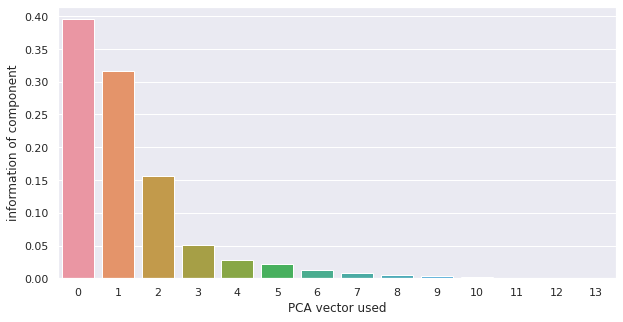

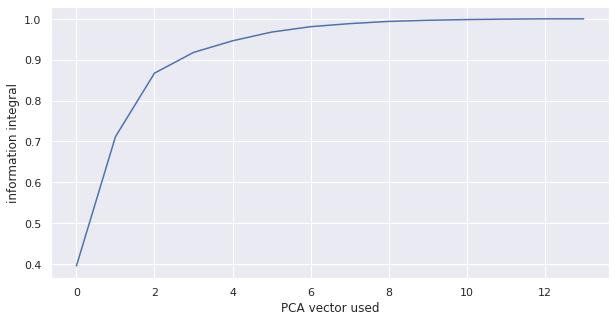

In [ ]:
apply_PCA(X_train)

# KNN classifier

*K-nearest neighbours* (K-NN) is an intuitive yet powerful non-linear classification algorithm. The training phase is not required as the model only needs to memorize the training data that will be used at test time. For each test sample a list of distances from the training points is computed and sorted in order to identify the k closest ones, the output class is then decided by majority voting among them. K-NN is therefore not very efficient from the computational point of view, however, especially in the case of small low-dimensional datasets, its ability to easily produce complex decision boundaries make it more useful than other simple algorithms.     
When data live in a high-dimensional space, K-NN starts suffering from the *curse of dimensionality* and its performances tend to worsen. This is a consequence of the fact that increasing the number of features makes points become more and more sparse, consequently reducing the meaning of the distance as a similarity measure between records. This issue is not very evident in the Leaf dataset due to its low dimensionality, as confirmed by the increasing trend in accuracy with respect to the number of principal components taken into account.     
KNN hyperparameters considered:
* K: number of nearest neighbours that take part in the voting procedure
   - 1, 2, 3, 4, 5, 6, 7, 8: the higher the number, the higher the generalization ability.
* Distance: the type of distance used to find the nearest neighbours
   - Manhattan (L1 norm):  $$ Manhattan(\vec{x},\vec{y})=\sum_{i=1}^d{\mid x_i-y_i\mid}$$
   - Euclidean (L2 norm):  $$ Euclidean(\vec{x},\vec{y})=\sqrt{\sum_{i=1}^d{(x_i-y_i)^2}}$$ 
* Weights: weight of each point in the voting procedure
   - Uniform: simple majority voting
   - Distance: closer points have more influence than the others

In [ ]:
knn_pca_results = [[] for i in range(14)]

In [ ]:
knn_hyperparameters = {
'weights':('uniform', 'distance'),
'metric': ['euclidean', 'manhattan'],
"n_neighbors" : [1,2,3,4,5,6,7,8]
}

In [ ]:
def knn_classifier(knn_hyperparameters, cvfolds_number, X_train, y_train):

  knn = KNeighborsClassifier()

  grid_search = GridSearchCV(knn, knn_hyperparameters, cv=KFold(cvfolds_number, shuffle=True, random_state=RANDOM_STATE), n_jobs= -1)
  grid_search.fit(X_train, y_train)
  knn_model = grid_search.best_estimator_

  return knn_model

In [ ]:
def KNN_pca(parameters, max_components, cvfolds_number, X_train, y_train, X_test, y_test, knn_pca_results):

  list_f1 = []

  for n_components in range(1, max_components+1):
    
    pca = PCA(n_components=n_components)
    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)

    knn_model = knn_classifier(parameters, 5, X_train_PCA, y_train)

    Y_pred = knn_model.predict(X_test_PCA)
    knn_f1 = round(f1_score(y_true = y_test,y_pred = Y_pred, average=AVERAGE, zero_division=0), 2)
    knn_pca_results[n_components-1].append(knn_f1)
    list_f1.append(knn_f1)

  
  plt.figure(figsize=(10,5))
  splot = sns.barplot(y=list_f1,x=[x for x in range(1,max_components+1)])
  
  for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() /2., p.get_height()), ha = 'center', va = 'center', 
                 xytext = (0, 10), textcoords = 'offset points')
  plt.show()

  return knn_pca_results

The graphs below show how the *f1-score* varies with the number of principal components using various sampling techniques  . 
The same analysis was also carried out in subsequent models with the aim of observing in detail the effect of PCA on them. As discussed before the accuracy with respect to the number of principal components tends to increase, showing the low impact of the *curse of dimensionality* on this dataset. 

Original data knn f1 pca components results


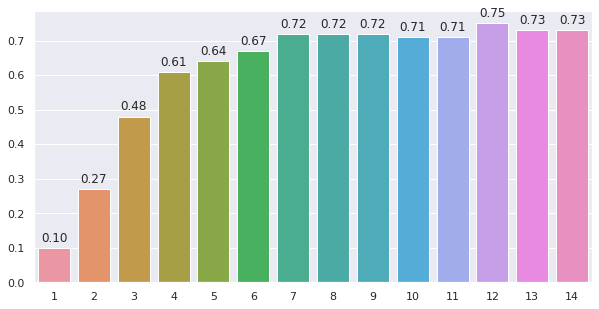

Over sampling data knn f1 pca components results


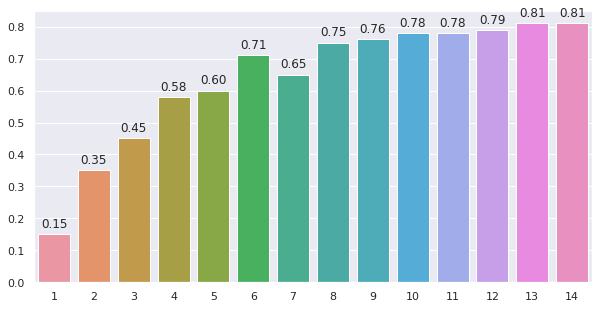

Under sampling data knn f1 pca components results


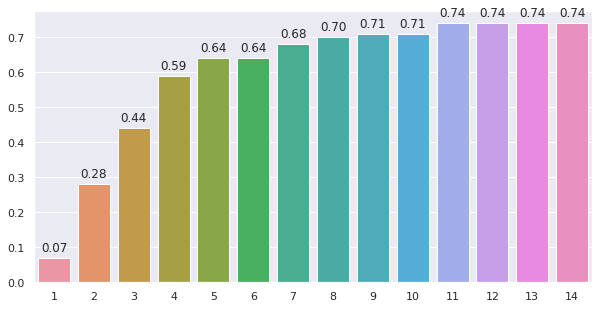

Over-under Sampling data knn f1 pca components results


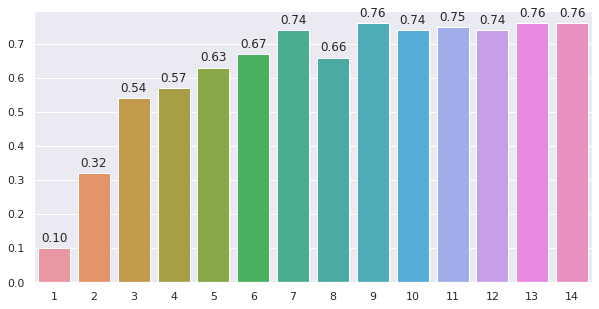

In [ ]:
print('Original data knn f1 pca components results')
knn_pca_results = KNN_pca(knn_hyperparameters, 14, 5, X_train_original, y_train_original, X_test_original, y_test, knn_pca_results)

print('Over sampling data knn f1 pca components results')
knn_pca_results = KNN_pca(knn_hyperparameters, 14, 5, X_train_over, y_train_over, X_test_over, y_test, knn_pca_results)

print('Under sampling data knn f1 pca components results')
knn_pca_results = KNN_pca(knn_hyperparameters, 14, 5, X_train_under, y_train_under, X_test_under, y_test, knn_pca_results)

print('Over-under Sampling data knn f1 pca components results')
knn_pca_results = KNN_pca(knn_hyperparameters, 14, 5, X_train, y_train, X_test, y_test, knn_pca_results)

In [ ]:
def knn_computations(parameters, data_dict, n_components):

  knn_matrix = []

  for samplingType in data_dict.keys():
      
    pca = PCA(n_components=n_components)
    
    X_train_PCA = pca.fit_transform(data_dict[samplingType][0])
    X_test_PCA = pca.transform(data_dict[samplingType][2])

    knn_model = knn_classifier(parameters, 5, X_train_PCA, data_dict[samplingType][1])
    Y_pred = knn_model.predict(X_test_PCA)
  
    list_result = []

    list_result.append(round(knn_model.score(X_test_PCA, data_dict[samplingType][3]), 2))
    list_result.append(round(precision_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))
    list_result.append(round(recall_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0),2))
    list_result.append(round(f1_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))

    knn_matrix.append(list_result)

  return knn_matrix

In [ ]:
knn_matrix = knn_computations(knn_hyperparameters, data_dict, 14)

list_f1_scores_classifier[2] = np.array(knn_matrix)[:,3]

In [ ]:
print_results(knn_matrix, data_dict, 'knn')

accuracy knn classifier - OriginalData : 0.73
precision knn classifier - OriginalData : 0.79
recall knn classifier - OriginalData : 0.73
f1 knn classifier - OriginalData : 0.73


accuracy knn classifier - OverSamplingData : 0.82
precision knn classifier - OverSamplingData : 0.83
recall knn classifier - OverSamplingData : 0.82
f1 knn classifier - OverSamplingData : 0.81


accuracy knn classifier - UnderSamplingData : 0.76
precision knn classifier - UnderSamplingData : 0.75
recall knn classifier - UnderSamplingData : 0.76
f1 knn classifier - UnderSamplingData : 0.74


accuracy knn classifier - OverUnderSamplingData : 0.76
precision knn classifier - OverUnderSamplingData : 0.82
recall knn classifier - OverUnderSamplingData : 0.76
f1 knn classifier - OverUnderSamplingData : 0.76




To compare the various metrics in relation to the different sampling techniques we decided to use all the main components in order to have a similar situation between the various techniques. This strategy was also adopted for the analysis of all the algorithms that we will see later. 

OverSampling and OverUnderSampling always perform better than the original data, while UnderSampling shows a similar behaviour. It is interesting to notice that OverSampling achieves results higher than 80% for every metric.

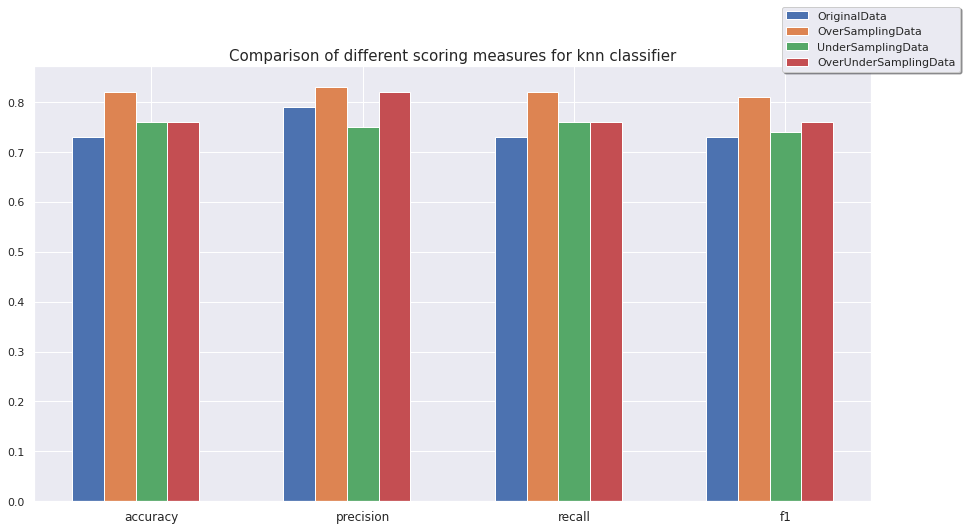

In [ ]:
plot_scores_of_given_model(knn_matrix, 'knn')

# Logistic regression

*Linear regression* is a very common and simple tool for predicting continuous response variables. Unfortunately, when it comes to dealing with categorical outputs, some problems like negative outputs or the need for thresholds may arise. Furthermore, *Linear regression* is not able to correctly interpret the encoding of categories in multiclass settings. To overcome these limitations a possible solution is *Logistic regression*, which applies a logistic sigmoid function to the output of the linear model.   
$$ \sigma(z) = \frac{1} {1 + e^{-z}} $$   
$$ \sigma(\beta_0 +\beta_1 x_1+...+\beta_n x_n) = \frac{1} {1 + e^{-(\beta_0 +\beta_1 x_1+...+\beta_n x_n)}} $$
The position and slope of the curve depend on its parameters $\beta_i$, which are learned at training time by maximum likelihood. The sigmoid function has the effect of squashing the output between $0$ and $1$, allowing it to be interpreted as a probability. We later have to define a threshold above which we classify $X$ as belonging to category 1.    

Rearranging the previous formula we can obtain the *logit* function, expressed as the natural logarithm of the ratio between the class probabilities:
$$\log{\frac{\mathbb{P}(X)}{1 - \mathbb{P}(X)}} = \beta_0 + \beta X$$
In multiclass settings we modify the previous formula to be able to obtain $K$ probabilities summing up to one.
$$\mathbb{P}(Y=k|X)=\frac{e^{\beta_{0k}+\beta_{1k}x_1+...+\beta_{nk}x_n}}{\sum_{i=1}^{K}{e^{\beta_{0i}+\beta_{1i}x_1+...+\beta_{ni}x_n}}}$$ This function is usually referred to as *softmax*, and the output class is the one with the highest probability.

In [ ]:
lr_parameters = {
    'penalty': ['l1', 'l2'], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

In [ ]:
lr_pca_results = [[] for i in range(14)]

In [ ]:
def lr_classifier(lr_parameters, cvfolds_number, X_train, y_train):

  lr = LogisticRegression(max_iter=2000)
  
  grid_search = GridSearchCV(lr, lr_parameters, cv=KFold(cvfolds_number, shuffle=True, random_state=RANDOM_STATE), n_jobs = -1)
  grid_search.fit(X_train, y_train)
  lr_model = grid_search.best_estimator_

  return lr_model

In [ ]:
def logisticRegression_pca(max_components, lr_parameters, cvfolds_number, X_train, y_train, X_test, y_test, lr_pca_results):

  list_f1 = []

  for n_components in range(1, max_components+1):
  
    pca = PCA(n_components=n_components)
    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)

    lr_model = lr_classifier(lr_parameters, 5, X_train_PCA, y_train)

    Y_pred = lr_model.predict(X_test_PCA)
    lr_f1 = round(f1_score(y_true = y_test,y_pred = Y_pred, average=AVERAGE, zero_division=0), 2)
    list_f1.append(lr_f1)
    lr_pca_results[n_components-1].append(lr_f1)

  plt.figure(figsize=(10,5))
  splot = sns.barplot(y=list_f1,x=[x for x in range(1,max_components+1)])
  
  for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() /2., p.get_height()), ha = 'center', va = 'center', 
                 xytext = (0, 10), textcoords = 'offset points')
  plt.show()

  return lr_pca_results

Original data logistic regression f1 pca components results


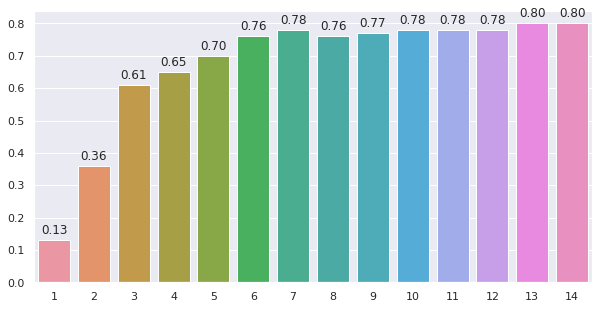

Oversampling data logistic regression f1 pca components results


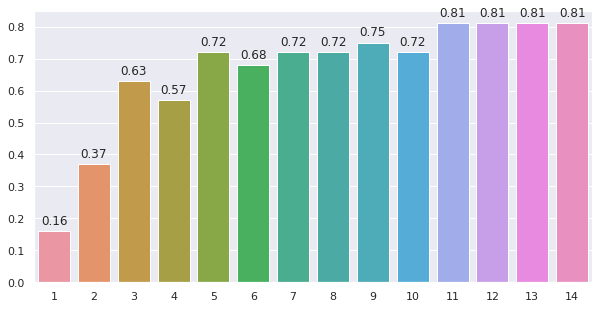

Undersampling data logistic regression f1 pca components results


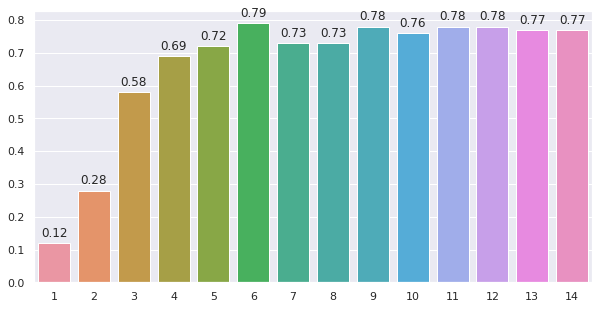

Over-under sampling data logistic regression f1 pca components results


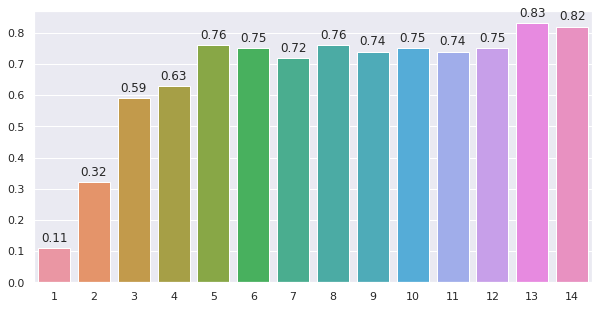

In [ ]:
print('Original data logistic regression f1 pca components results')
lr_pca_results = logisticRegression_pca(14, lr_parameters, 5, X_train_original, y_train_original, X_test_original, y_test, lr_pca_results)

print('Oversampling data logistic regression f1 pca components results')
lr_pca_results = logisticRegression_pca(14, lr_parameters, 5, X_train_over, y_train_over, X_test_over, y_test, lr_pca_results)

print('Undersampling data logistic regression f1 pca components results')
lr_pca_results = logisticRegression_pca(14, lr_parameters, 5, X_train_under, y_train_under, X_test_under, y_test, lr_pca_results)

print('Over-under sampling data logistic regression f1 pca components results')
lr_pca_results = logisticRegression_pca(14, lr_parameters, 5, X_train, y_train, X_test, y_test, lr_pca_results)

In [ ]:
def lr_computations(parameters, data_dict, n_components):

  lr_matrix = []

  for samplingType in data_dict.keys():
      
    pca = PCA(n_components=n_components)
    
    X_train_PCA = pca.fit_transform(data_dict[samplingType][0])
    X_test_PCA = pca.transform(data_dict[samplingType][2])

    lr_model = lr_classifier(parameters, 5, X_train_PCA, data_dict[samplingType][1])
    Y_pred = lr_model.predict(X_test_PCA)
  
    list_result = []
    list_result.append(round(lr_model.score(X_test_PCA, data_dict[samplingType][3]), 2))
    list_result.append(round(precision_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))
    list_result.append(round(recall_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0),2))
    list_result.append(round(f1_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))

    lr_matrix.append(list_result)

  return lr_matrix

In [ ]:
lr_matrix = lr_computations(lr_parameters, data_dict, 14)

list_f1_scores_classifier[3] = np.array(lr_matrix)[:,3]

In [ ]:
print_results(lr_matrix, data_dict, 'logistic regression')

accuracy logistic regression classifier - OriginalData : 0.83
precision logistic regression classifier - OriginalData : 0.82
recall logistic regression classifier - OriginalData : 0.82
f1 logistic regression classifier - OriginalData : 0.8


accuracy logistic regression classifier - OverSamplingData : 0.83
precision logistic regression classifier - OverSamplingData : 0.84
recall logistic regression classifier - OverSamplingData : 0.82
f1 logistic regression classifier - OverSamplingData : 0.81


accuracy logistic regression classifier - UnderSamplingData : 0.8
precision logistic regression classifier - UnderSamplingData : 0.8
recall logistic regression classifier - UnderSamplingData : 0.8
f1 logistic regression classifier - UnderSamplingData : 0.77


accuracy logistic regression classifier - OverUnderSamplingData : 0.83
precision logistic regression classifier - OverUnderSamplingData : 0.87
recall logistic regression classifier - OverUnderSamplingData : 0.83
f1 logistic regression clas

OverUnderSampling is always the best performing technique, but results are overall quite similar.

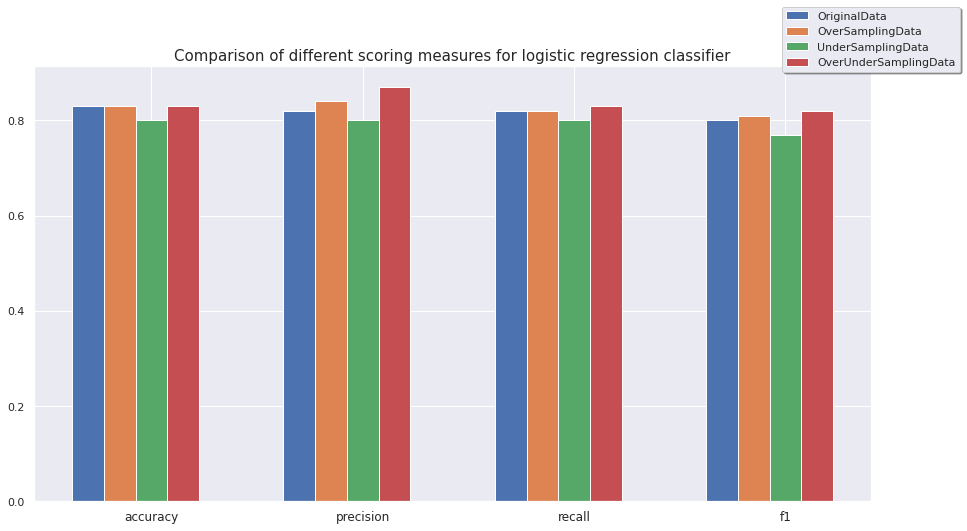

In [ ]:
plot_scores_of_given_model(lr_matrix, 'logistic regression')

# SVM

*Support Vector Machine* (SVM) is a supervised learning algorithm that can be used, similarly to the decision tree, both for classification and regression. 
This algorithm as a classifier can also be used when there are more than two classes. For the description of the theory behind this we will refer to the binary case and at the end we will introduce how to use this algorithm in the more general case that corresponds to the one we faced in our analysis.    
The objective of this algorithm is to find a hyperplane that distinctly classifies the data points. Since to separate two classes there are many hyperplanes that could be chosen our objective is to find the plane that has the *maximum margin*. The margin can be defined as
the minimal distance between the plane and the data. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence. This formulation takes the name of **Hard Margin** SVM and could be described with the following formula:

$$ arg\max_{\parallel{w}\parallel=1, (w,b)} \min_{i\in[m]} \mid\langle w,x_i\rangle + b\mid \quad s.t \\ \forall i, \quad y_i[\langle w, x_i\rangle + b] > 0$$

Hyperplanes are decision boundaries that help classify the data points. Data points falling on either side of the hyperplane can be attributed to different classes. Also, the dimension of the hyperplane depends upon the number of features. If the number of input features is 2, then the hyperplane is just a line. When an unlabeled data is passed to the algorithm, it predicts the label to be associated with it based on this decision function: $\langle w, x_i\rangle + b$. This product defines the position of the data relative to the plane.

If data are not linearly separable, the hard margin SVM is not feasible. For this reason, a second formulation of the problem is also defined, called **Soft margin**. We allow the constraint defined in the Hard Margin to be violated. The algorithm allow some points to enter in the region defined by the margin or even go on the other side. 
The key of this process is to do it in a controlled way by introducing a new variable $\xi$ also called Slack variable. The objective function in this formulation is the following:

$$\arg\min_{w,b} \frac {1}{2}\parallel{w^2}\parallel + C\sum_i{\xi_i} \quad s.t \\ \forall i, \quad y_i[\langle w, x_i\rangle + b] \geq 1-\xi_i, \quad \xi_i \geq 0$$

The hyperparameter $C$ is introduced. It tells how much we want to avoid misclassifying each training sample. 
Small values of $C$ imply that in the process of minimization the weight related to slack variables is very small and therefore implies that the optimizer focuses more on increasing the size of the margin, thus leading to a higher error. High values ​​of $C$ instead lead to a smaller number of errors and to smaller margin-hyperplane.This value strongly affects the decision boundaries of our model.

A further solution to the problem of non-linearly separable data is defined with the term *kernel trick*. SVM can be written exclusively in terms of scalar products between samples. What is introduced by the kernel trick solution is to replace the dot product with a particular function called the kernel. This symmetric, positive semidefinite function implements an inner product in some hilbert space. The kernel trick allows us to try and find a separating hyperplane in a higher dimensional space, since the higher the dimensionality the more the data are likely to be linearly separable. There are many kernel functions and the challenge is to find the one that best solves the problem.

Although *Support Vector Machines* is to be considered as a strictly binary classifier, there are different strategies with which we can use an ensemble for multiclass predictions. Let's see two of them.
The *One Versus All method* (*OvA*), often called *One Versus The Rest*, involves the use of as many binary classifiers as there are classes to predict, each trained to recognize a specific class.
The *One Versus One* (*OvO*) trains one classifier for each pair of classes. The main advantage of this method is that each classifier needs to be trained only in a subset of the dataset containing only the classes to be distinguished. Scikit – Learn automatically runs the *OvA* if we try to use a binary classifier for a multi-class problem.


## Linear SVM

In [ ]:
lin_sv_parameters = {
    'C': [1, 5, 10, 50, 100],
    'loss': ['hinge', 'squared_hinge']
    #'max_iter': [4000]
  }

@ignore_warnings(category=ConvergenceWarning)
def linear_support_vectors_classifier(parameters, cvfolds_number, X_train, y_train):

  sv_clsf = svm.LinearSVC(max_iter=4000)
  grid_search = GridSearchCV(sv_clsf, parameters, cv=KFold(cvfolds_number, shuffle=True, random_state=RANDOM_STATE))
  grid_search.fit(X_train, y_train)


  return grid_search.best_estimator_

In [ ]:
linear_svm_pca_results = [[] for i in range(14)]

In [ ]:
def pca_linear_support_vectors(parameters, max_components, cvfolds_number, X_train, y_train, X_test, y_test, linear_svm_pca_results):

  list_f1 = []

  for n_components in range(1, max_components+1):
    
    pca = PCA(n_components=n_components)
    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)

    svc_model = linear_support_vectors_classifier(parameters, 5, X_train_PCA, y_train)

    Y_pred = svc_model.predict(X_test_PCA)
    svc_f1 = round(f1_score(y_true = y_test,y_pred = Y_pred, average=AVERAGE, zero_division=0), 2)
    list_f1.append(svc_f1)
    linear_svm_pca_results[n_components-1].append(svc_f1)
  
  plt.figure(figsize=(10,5))
  splot = sns.barplot(y=list_f1,x=[x for x in range(1,max_components+1)])
  
  for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() /2., p.get_height()), ha = 'center', va = 'center', 
                 xytext = (0, 10), textcoords = 'offset points')
  plt.show()

  return linear_svm_pca_results

Original data linear support vector f1 pca components results


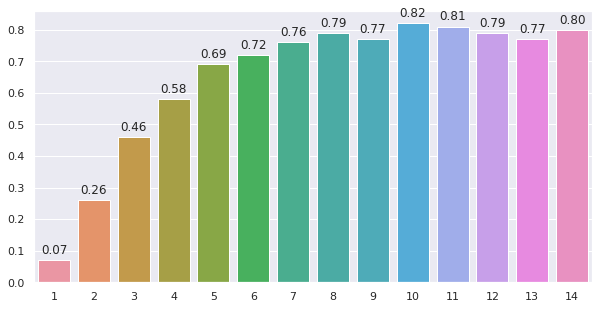

Oversampling data linear support vector f1 pca components results


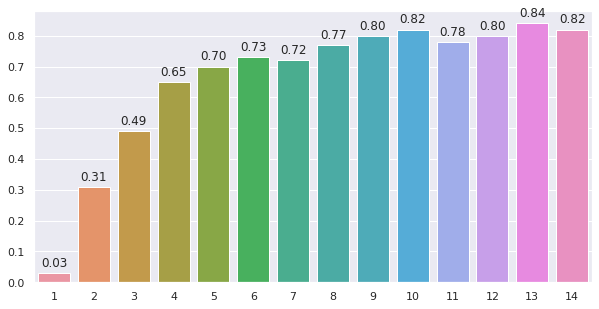

Undersampling data linear support vector f1 pca components results


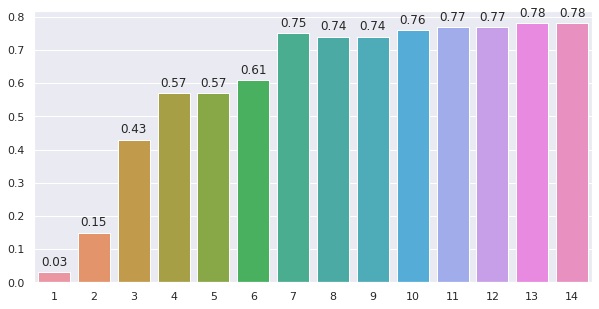

Over-under sampling data linear support vector f1 pca components results


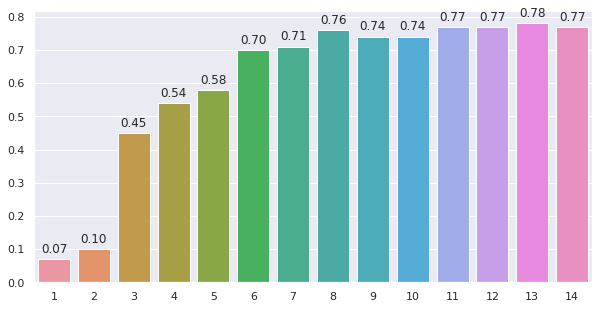

In [ ]:
print('Original data linear support vector f1 pca components results')
linear_svm_pca_results = pca_linear_support_vectors(lin_sv_parameters, 14, 5, X_train_original, y_train_original, X_test_original, y_test, linear_svm_pca_results)

print('Oversampling data linear support vector f1 pca components results')
linear_svm_pca_results = pca_linear_support_vectors(lin_sv_parameters, 14, 5, X_train_over, y_train_over, X_test_over, y_test, linear_svm_pca_results)

print('Undersampling data linear support vector f1 pca components results')
linear_svm_pca_results = pca_linear_support_vectors(lin_sv_parameters, 14, 5, X_train_under, y_train_under, X_test_under, y_test, linear_svm_pca_results)

print('Over-under sampling data linear support vector f1 pca components results')
linear_svm_pca_results = pca_linear_support_vectors(lin_sv_parameters, 14, 5, X_train, y_train, X_test, y_test, linear_svm_pca_results)

In [ ]:
def lin_sv_computations(parameters, data_dict, n_components):

  lin_sv_matrix = []

  for samplingType in data_dict.keys():

    pca = PCA(n_components=n_components)
    
    X_train_PCA = pca.fit_transform(data_dict[samplingType][0])
    X_test_PCA = pca.transform(data_dict[samplingType][2])

    lin_sv_model = linear_support_vectors_classifier(parameters, 5, X_train_PCA, data_dict[samplingType][1])
    Y_pred = lin_sv_model.predict(X_test_PCA)
  
    list_result = []
    list_result.append(round(lin_sv_model.score(X_test_PCA, data_dict[samplingType][3]), 2))
    list_result.append(round(precision_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))
    list_result.append(round(recall_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0),2))
    list_result.append(round(f1_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))

    lin_sv_matrix.append(list_result)

  return lin_sv_matrix

In [ ]:
lin_sv_matrix = lin_sv_computations(lin_sv_parameters, data_dict, 14)

list_f1_scores_classifier[4] = np.array(lin_sv_matrix)[:,3]

In [ ]:
print_results(lin_sv_matrix, data_dict, 'linear SVC')

accuracy linear SVC classifier - OriginalData : 0.8
precision linear SVC classifier - OriginalData : 0.81
recall linear SVC classifier - OriginalData : 0.8
f1 linear SVC classifier - OriginalData : 0.78


accuracy linear SVC classifier - OverSamplingData : 0.83
precision linear SVC classifier - OverSamplingData : 0.86
recall linear SVC classifier - OverSamplingData : 0.83
f1 linear SVC classifier - OverSamplingData : 0.82


accuracy linear SVC classifier - UnderSamplingData : 0.8
precision linear SVC classifier - UnderSamplingData : 0.79
recall linear SVC classifier - UnderSamplingData : 0.81
f1 linear SVC classifier - UnderSamplingData : 0.78


accuracy linear SVC classifier - OverUnderSamplingData : 0.8
precision linear SVC classifier - OverUnderSamplingData : 0.78
recall linear SVC classifier - OverUnderSamplingData : 0.81
f1 linear SVC classifier - OverUnderSamplingData : 0.77




OverSampling is the best technique, UnderSampling and OverUnderSampling are the worst. The results of all the different sampling strategies are quite comparable overall.

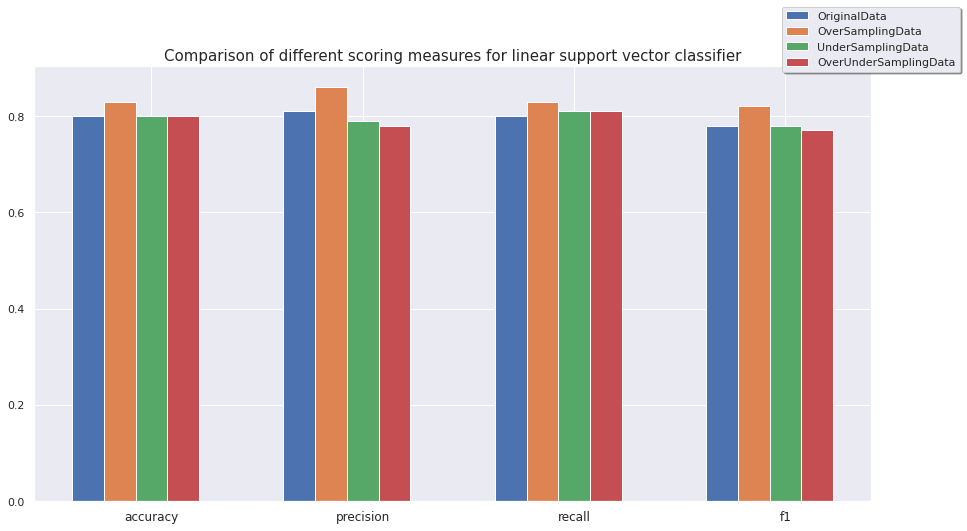

In [ ]:
plot_scores_of_given_model(lin_sv_matrix, 'linear support vector')

## Non-linear SVM



In [ ]:
sv_parameters = {
    'C': [1, 5, 10, 50, 100],
    'kernel':['poly', 'rbf'],
    'break_ties': [True]
  }

def support_vectors_classifier(parameters, cvfolds_number, X_train, y_train):

  sv_clsf = svm.SVC()
  grid_search = GridSearchCV(sv_clsf, parameters, cv=KFold(cvfolds_number, shuffle=True, random_state=RANDOM_STATE))
  grid_search.fit(X_train, y_train)

  return grid_search.best_estimator_

In [ ]:
svm_pca_results = [[] for i in range(14)]

In [ ]:
def pca_support_vectors(parameters, max_components, cvfolds_number, X_train, y_train, X_test, y_test, svm_pca_results):

  list_f1 = []

  for n_components in range(1, max_components+1):
    
    pca = PCA(n_components=n_components)
    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)

    svc_model = support_vectors_classifier(parameters, 5, X_train_PCA, y_train)

    Y_pred = svc_model.predict(X_test_PCA)
    svc_f1 = round(f1_score(y_true = y_test,y_pred = Y_pred, average=AVERAGE, zero_division=0), 2)
    list_f1.append(svc_f1)
    svm_pca_results[n_components-1].append(svc_f1)

  plt.figure(figsize=(10,5))
  splot = sns.barplot(y=list_f1,x=[x for x in range(1,max_components+1)])
  
  for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() /2., p.get_height()), ha = 'center', va = 'center', 
                 xytext = (0, 10), textcoords = 'offset points')
  plt.show()

  return svm_pca_results

Original data support vector f1 pca components results


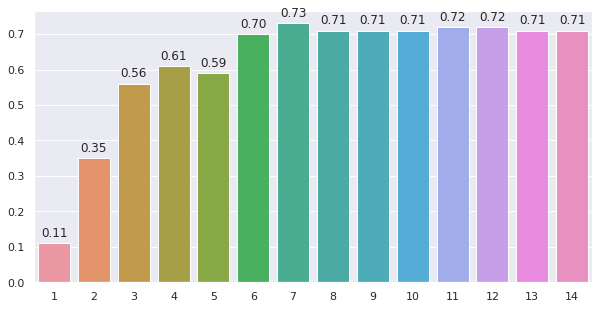

Oversampling data support vector f1 pca components results


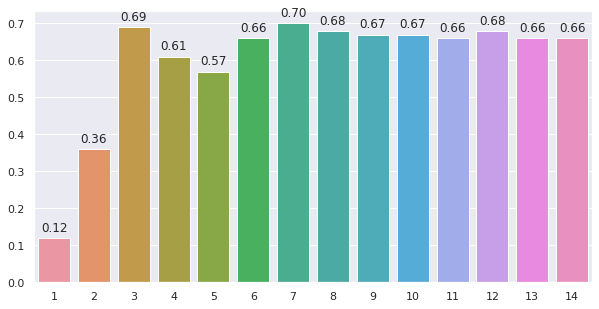

Undersampling data support vector f1 pca components results


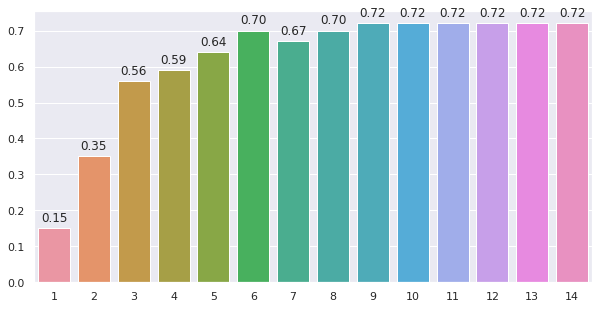

Over-under sampling data support vector f1 pca components results


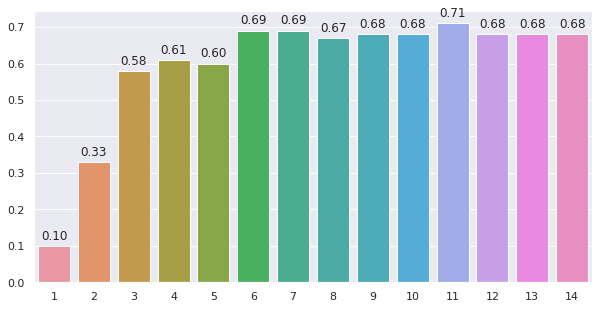

In [ ]:
print('Original data support vector f1 pca components results')
svm_pca_results = pca_support_vectors(sv_parameters, 14, 5, X_train_original, y_train_original, X_test_original, y_test, svm_pca_results)

print('Oversampling data support vector f1 pca components results')
svm_pca_results = pca_support_vectors(sv_parameters, 14, 5, X_train_over, y_train_over, X_test_over, y_test, svm_pca_results)

print('Undersampling data support vector f1 pca components results')
svm_pca_results = pca_support_vectors(sv_parameters, 14, 5, X_train_under, y_train_under, X_test_under, y_test, svm_pca_results)

print('Over-under sampling data support vector f1 pca components results')
svm_pca_results = pca_support_vectors(sv_parameters, 14, 5, X_train, y_train, X_test, y_test, svm_pca_results)

In [ ]:
def sv_computations(parameters, data_dict, n_components):

  sv_matrix = []

  for samplingType in data_dict.keys():

    pca = PCA(n_components=n_components)
    
    X_train_PCA = pca.fit_transform(data_dict[samplingType][0])
    X_test_PCA = pca.transform(data_dict[samplingType][2])

    sv_model = support_vectors_classifier(parameters, 5, X_train_PCA, data_dict[samplingType][1])
    Y_pred = sv_model.predict(X_test_PCA)
  
    list_result = []
    list_result.append(round(sv_model.score(X_test_PCA, data_dict[samplingType][3]), 2))
    list_result.append(round(precision_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))
    list_result.append(round(recall_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0),2))
    list_result.append(round(f1_score(data_dict[samplingType][3], Y_pred, average=AVERAGE, zero_division=0), 2))

    sv_matrix.append(list_result)

  return sv_matrix

In [ ]:
sv_matrix = sv_computations(sv_parameters, data_dict, 14)

list_f1_scores_classifier[5] = np.array(sv_matrix)[:,3]

In [ ]:
print_results(sv_matrix, data_dict, 'non-linear SVC')

accuracy non-linear SVC classifier - OriginalData : 0.73
precision non-linear SVC classifier - OriginalData : 0.74
recall non-linear SVC classifier - OriginalData : 0.72
f1 non-linear SVC classifier - OriginalData : 0.71


accuracy non-linear SVC classifier - OverSamplingData : 0.7
precision non-linear SVC classifier - OverSamplingData : 0.65
recall non-linear SVC classifier - OverSamplingData : 0.69
f1 non-linear SVC classifier - OverSamplingData : 0.66


accuracy non-linear SVC classifier - UnderSamplingData : 0.76
precision non-linear SVC classifier - UnderSamplingData : 0.73
recall non-linear SVC classifier - UnderSamplingData : 0.76
f1 non-linear SVC classifier - UnderSamplingData : 0.72


accuracy non-linear SVC classifier - OverUnderSamplingData : 0.7
precision non-linear SVC classifier - OverUnderSamplingData : 0.73
recall non-linear SVC classifier - OverUnderSamplingData : 0.69
f1 non-linear SVC classifier - OverUnderSamplingData : 0.68




OverSampling and OverUnderSampling always perform worse than the OriginalData, that is almost constant regardless of the chosen metric.

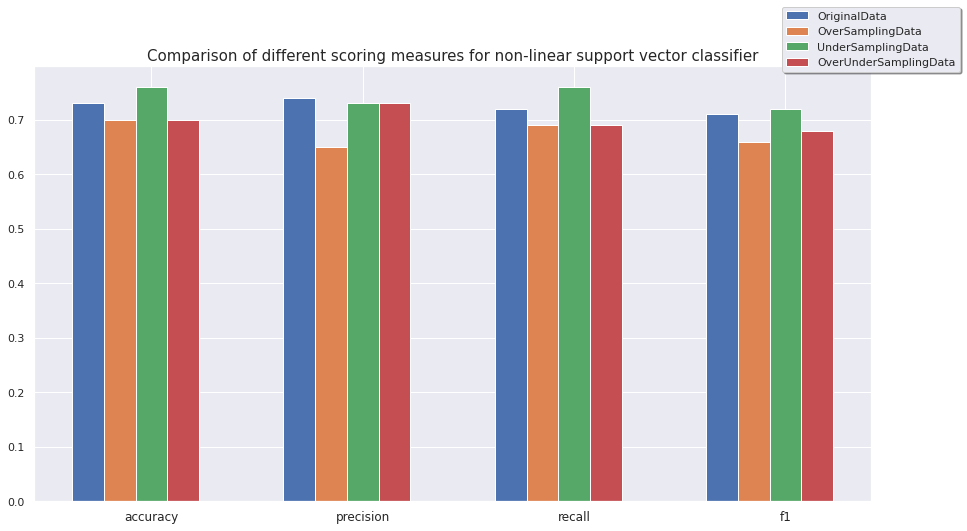

In [ ]:
plot_scores_of_given_model(sv_matrix, 'non-linear support vector')

#Conclusions

The main goal of our analysis was to test some simple classification algorithms on a multiclass problem. For each of them we computed several metrics for performance evaluation: Accuracy, Recall, Precision and f1-score. In order to compare them we used the f1-score since it better captures different aspects of the models' behaviour. The following graph shows the scores obtained by the final model produced by each algorithm on the training sets resulting from different sampling techniques.    
We can observe that K-NN, Logistic Regression and Linear SVM can reach peaks above 80% (a reasonable value considering the number of classes). Random Forest and SVM follow with similar results, Decision Tree is the least effective.    
Only in the case of Random Forest the original data perform better than all the sampling techniques we applied.   


In [ ]:
def plot_single_score_different_models(scoring_matrix, score_metric_name):

  classifiers = ['Decision Tree', 'Random Forest', 'KNN', 'Logistic Regression', 'Linear SVM', 'SVM']
  sampling_methods = ['OriginalData', 'OverSamplingData', 'UnderSamplingData', 'OverUnderSamplingData']

  x_groups = len(classifiers)
  element_per_group = len(sampling_methods)
  index = np.arange(x_groups)
  width = 0.15

  fig, ax = plt.subplots(1,1, figsize=(15,8))
  plots = [None] * element_per_group
  elements = np.array(scoring_matrix)

  for i in range(element_per_group):
    plots[i] = ax.bar(index + i*width, elements[:, i], width=width, label=sampling_methods[i])

  ax.set_title(f'Comparison of {score_metric_name} scoring metric for different sampling methods and classifiers', fontsize = 15)
  ax.set_xticklabels(classifiers, fontsize=12)
  ax.set_xticks(index + width * element_per_group / 2)
  ax.legend(plots, sampling_methods, loc='upper center', bbox_to_anchor=(1, 1.15),
            ncol=1, fancybox=True, shadow=True)

  plt.show()

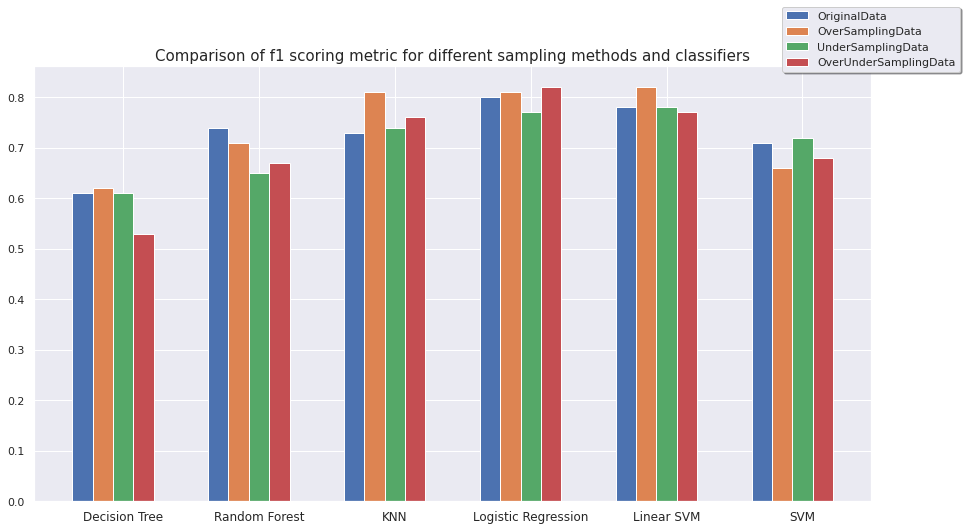

In [ ]:
plot_single_score_different_models(list_f1_scores_classifier, 'f1')

The main challenge posed by the Leaf dataset is the high number of classes, which prevented us from being able to easily visualize the data and the results obtained by our models. Furthermore, the cardinality of the dataset is very low with respect to the number of classes, making it harder for the algorithms to learn how to discriminate between them. Many of the techniques we chose to apply (e.g. oulier removal, pca and class balance) were arguably not needed due to the characteristics of our data. Neverheless we decided to try them in order to experience their effects in a real-world scenario. The results we obtained show that some of them indeed do provide a benefit: for instance, the OverUnderSampling strategy which gives the tied best result for f1-score across all models.